# 生成字体步骤

- 获取字符列表
- 从字体中提取子集，合并成一个完整的字体文件
- 生成不同 size 与 bpp 的点阵字体

## 获取字符列表

这里使用 DeepSeek 的词表来提取常用字符

In [1]:
# 安装 modelscope
!pip install modelscope transformers

In [ ]:
from tqdm import tqdm
from modelscope import AutoTokenizer
import os

# 创建临时目录
if not os.path.exists("build"):
    os.makedirs("build")



unique_chars = {}  # 存储字符和对应的token ID


def extract_chars_from_model(model_name):
    print(f"Extracting chars from {model_name}...")
    # load the tokenizer and the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    for id in tqdm(range(len(tokenizer.get_vocab()))):
        token = tokenizer.decode(id)
        if token.startswith("<｜"):
            continue
        # 对于每个字符，记录最小的token ID
        for char in token:
            if char not in unique_chars:
                unique_chars[char] = id

extract_chars_from_model("deepseek-ai/DeepSeek-R1-0528")
extract_chars_from_model("Qwen/Qwen3-235B-A22B-Instruct-2507")

# count total unique chars
print(f"Total unique chars: {len(unique_chars)}")

sorted_chars = sorted(unique_chars.items(), key=lambda x: x[1])
# write to file - 按照token ID排序
with open("./build/chars.txt", "w") as f:
    # 按照token ID排序输出
    for char, token_id in sorted_chars:
        f.write(char + "\n")

print(f"Wrote {len(unique_chars)} unique characters to unique_chars.txt (sorted by token ID)")

## 从字体中提取子集

字体文件可以从 https://www.alibabafonts.com/ 或 https://fonts.google.com/noto 下载到 fonts 目录下

In [4]:
!pip install fonttools

In [11]:
import os
import shutil
import json
from fontTools.subset import Subsetter, Options, load_font, save_font
from fontTools.merge import Merger
from fontTools.ttLib.scaleUpem import scale_upem

print(f"Building subsetter")
basic_unicodes = set(range(0x20, 0x7f)) | set(range(0xA1, 0x100))
for parent, dirs, files in os.walk("../../main/assets/locales"):
    for filename in files:
        if filename == 'language.json':
            with open(os.path.join(parent, filename), 'r') as f:
                strings = json.load(f)["strings"]
                # Add all values to unicodes
                for value in strings.values():
                    for char in value:
                        basic_unicodes.add(ord(char))
print(f"basic_unicodes: Added {len(basic_unicodes)} chars from assets")

qwen_unicodes = basic_unicodes.copy()
for char, token_id in sorted_chars:
    qwen_unicodes.add(ord(char))
print(f"qwen_unicodes: Added chars: {len(qwen_unicodes)}")

font_list = []

def build_ttf(font_type, font_style, font_name, unicodes):
    global font_list
    font_list = [
        f"fonts/Noto_Sans/static/NotoSans-{font_style}.ttf",
        f"fonts/Noto_Emoji/static/NotoEmoji-{font_style}.ttf",
        f"fonts/Noto_Sans_SC/static/NotoSansSC-{font_style}.ttf",
        f"fonts/Noto_Sans_TC/static/NotoSansTC-{font_style}.ttf",
        f"fonts/Noto_Sans_JP/static/NotoSansJP-{font_style}.ttf",
        f"fonts/Noto_Sans_KR/static/NotoSansKR-{font_style}.ttf",
        f"fonts/Noto_Sans_Thai/static/NotoSansThai-{font_style}.ttf",
        f"fonts/Noto_Sans_Arabic/static/NotoSansArabic-{font_style}.ttf"
    ]
    # font_list = [
    #     f"fonts/AlibabaSans/AlibabaSans-{font_style}/AlibabaSans-{font_style}.ttf",
    #     f"fonts/AlibabaPuHuiTi-3/AlibabaPuHuiTi-3-55-{font_style}/AlibabaPuHuiTi-3-55-{font_style}.ttf",
    #     f"fonts/AlibabaSansJP/AlibabaSansJP-{font_style}/AlibabaSansJP-{font_style}.ttf",
    #     f"fonts/AlibabaSansKR/AlibabaSansKR-{font_style}/AlibabaSansKR-{font_style}.ttf",
    #     f"fonts/AlibabaSansTC/AlibabaSansTC-55/AlibabaSansTC-55.ttf",
    #     f"fonts/AlibabaSansThai/AlibabaSansThai-Rg/AlibabaSansThai-Rg.ttf",
    #     f"fonts/AlibabaSansViet/AlibabaSansViet-Rg/AlibabaSansViet-Rg.ttf",
    # ]

    if not os.path.exists(f"build/subsets"):
        os.makedirs(f"build/subsets")

    print(f"Subsetting {len(font_list)} fonts")
    subset_fonts = []
    subsetter = Subsetter(Options())
    subsetter.populate(unicodes=list(unicodes))
    # 遍历 font_list，提取每个字体中的字符
    for font_path in tqdm(font_list):
        if not os.path.exists(font_path):
            print(f"Font {font_path} not found")
            continue
        font = load_font(font_path, Options())
        font_file = font_path.split('/')[-1].split('.')[0]
        subsetter.subset(font)
        scale_upem(font, 1000)
        save_path = f"build/subsets/{font_file}.ttf"
        font.save(save_path)
        subset_fonts.append(save_path)

    # 合并所有字体，保存到 build/puhui-{len(unicodes)}-{style}.ttf
    print(f"Merging {len(subset_fonts)} fonts")
    output_path = f"ttf/{font_type}-{font_name}.ttf"
    cmd = f"fonttools merge {" ".join(subset_fonts)} --output-file={output_path} --drop-tables=vhea,vmtx"
    os.system(cmd)
    print(f"Merged font saved to {output_path}")


build_ttf("noto", "Regular", "basic", basic_unicodes)
build_ttf("noto", "Regular", "qwen", qwen_unicodes)

Building subsetter
basic_unicodes: Added 901 chars from assets
qwen_unicodes: Added chars: 18409
Subsetting 8 fonts


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Merging 8 fonts
Merged font saved to ttf/noto-basic.ttf
Subsetting 8 fonts


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Merging 8 fonts
Merged font saved to ttf/noto-qwen.ttf


## 生成不同 size 与 bpp 的点阵字体

字体: ttf/noto-qwen.ttf, 大小: 20px, BPP: 1


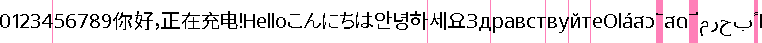

字体: ttf/noto-qwen.ttf, 大小: 20px, BPP: 2


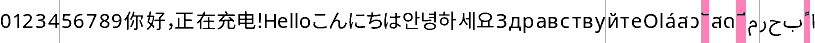

字体: ttf/noto-qwen.ttf, 大小: 20px, BPP: 3


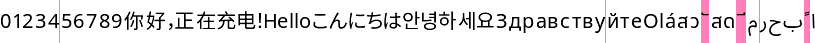

字体: ttf/noto-qwen.ttf, 大小: 20px, BPP: 4


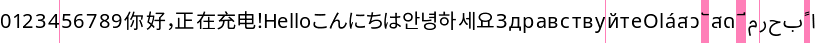

In [13]:
import os
from PIL import Image
import json
from IPython.display import display

# https://github.com/78/lv_font_conv (Support cbin format)
lv_font_conv = "node ./tmp/lv_font_conv/lv_font_conv.js"
flags = "--force-fast-kern-format --no-compress --no-prefilter "

def preview_font(font_path, size, bpp):
    symbols_str = "0123456789你好，正在充电！Helloこんにちは안녕하세요ЗдравствуйтеOláสวัสดีمرحبًا"
    output = "./build/preview"
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)
    cmd = f"{lv_font_conv} {flags} --font {font_path} --format dump --bpp {bpp} -o {output} --size {size} --symbols {symbols_str} "
    os.system(cmd)
    
    # 读取字体信息
    font_info_path = os.path.join(output, "font_info.json")
    if not os.path.exists(font_info_path):
        print("未找到font_info.json文件")
        return
        
    with open(font_info_path, 'r', encoding='utf-8') as f:
        font_info = json.load(f)
    
    # 获取字体高度信息
    font_height = font_info.get('size', size)
    ascent = font_info.get('ascent', font_height)
    descent = font_info.get('descent', 0)
    
    # 收集所有PNG文件并按照字符顺序排序
    png_files = []
    char_positions = {}  # 存储每个字符在原始字符串中的位置
    
    for i, char in enumerate(symbols_str):
        unicode_hex = f"{ord(char):x}.png"
        png_path = os.path.join(output, unicode_hex)
        if os.path.exists(png_path):
            png_files.append((char, png_path, i))
            char_positions[char] = i
    
    # 按照原始字符串顺序排序
    png_files.sort(key=lambda x: x[2])
    
    if not png_files:
        print("未找到任何PNG文件")
        return
    
    # 加载所有图片并计算总尺寸
    images = []
    total_width = 0
    max_height = 0
    
    for char, png_path, _ in png_files:
        try:
            img = Image.open(png_path).convert('RGBA')
            images.append((char, img))
            total_width += img.width + 2  # 添加2像素间距
            max_height = max(max_height, img.height)
        except Exception as e:
            print(f"无法加载图片 {png_path}: {e}")
            continue
    
    if not images:
        print("没有成功加载任何图片")
        return
    
    # 移除最后一个字符的间距
    total_width -= 2
    
    # 创建预览图画布，使用字体高度作为画布高度
    canvas_height = max(max_height, font_height + 10)  # 添加一些padding
    canvas = Image.new('RGBA', (total_width, canvas_height), (255, 255, 255, 255))
    
    # 拼接图片
    x_offset = 0
    for char, img in images:
        # 计算垂直居中位置
        y_offset = (canvas_height - img.height) // 2
        canvas.paste(img, (x_offset, y_offset), img)
        x_offset += img.width + 2
    
    # 打印字符信息
    print(f"字体: {font_path}, 大小: {size}px, BPP: {bpp}")
    
    # 在 notebook 中直接显示图片
    display(canvas)
    
    return canvas

# 调用函数并显示图片
font_size = 20
for bpp in [1, 2, 3, 4]:
    preview_image = preview_font("ttf/noto-qwen.ttf", font_size, bpp)

In [14]:

flags = "--force-fast-kern-format --no-compress --no-prefilter "

def generate_font_source(font_path, name, size, bpp):
    output = f"src/font_{name}_{size}_{bpp}.c"
    print(f"Generating {output}...")
    cmd = f"{lv_font_conv} {flags} --font {font_path} --format lvgl --lv-include lvgl.h --bpp {bpp} -o {output} --size {size} -r 0x0-0xfffff"
    os.system(cmd)

generate_font_source("ttf/noto-basic.ttf", "noto_basic", 14, 1)
generate_font_source("ttf/noto-basic.ttf", "noto_basic", 16, 4)
generate_font_source("ttf/noto-basic.ttf", "noto_basic", 20, 4)
generate_font_source("ttf/noto-basic.ttf", "noto_basic", 30, 4)

Generating src/font_noto_basic_14_1.c...
Forced faster kerning format (via classes). Size increase is 3372 bytes.
Generating src/font_noto_basic_16_4.c...
Forced faster kerning format (via classes). Size increase is 3372 bytes.
Generating src/font_noto_basic_20_4.c...
Forced faster kerning format (via classes). Size increase is 3372 bytes.
Generating src/font_noto_basic_30_4.c...
Forced faster kerning format (via classes). Size increase is 3372 bytes.


In [15]:
def generate_font_cbin(font_path, name, size, bpp):
    output = f"cbin/font_{name}_{size}_{bpp}.bin"
    print(f"Generating {output}...")
    cmd = f"{lv_font_conv} {flags} --font {font_path} --format cbin --bpp {bpp} -o {output} --size {size} -r 0x0-0xfffff"
    os.system(cmd)

# Generate cbin font
generate_font_cbin("ttf/noto-qwen.ttf", "noto_qwen", 14, 1)
generate_font_cbin("ttf/noto-qwen.ttf", "noto_qwen", 16, 4)
generate_font_cbin("ttf/noto-qwen.ttf", "noto_qwen", 20, 4)
generate_font_cbin("ttf/noto-qwen.ttf", "noto_qwen", 30, 4)

Generating cbin/font_noto_qwen_14_1.bin...
Forced faster kerning format (via classes). Size increase is 41696 bytes.
Generating cbin/font_noto_qwen_16_4.bin...
Forced faster kerning format (via classes). Size increase is 41696 bytes.
Generating cbin/font_noto_qwen_20_4.bin...
Forced faster kerning format (via classes). Size increase is 41696 bytes.
Generating cbin/font_noto_qwen_30_4.bin...
Forced faster kerning format (via classes). Size increase is 41696 bytes.


In [36]:
import multiprocessing as mp
from functools import partial
import os
import shutil

build_dir = "build/full"
if os.path.exists(build_dir):
    shutil.rmtree(build_dir)
os.makedirs(build_dir)

def generate_font_full_bin(args):
    """单个字体生成任务"""
    font_path, name, size, bpp = args
    output = f"{build_dir}/{name}_{size}_{bpp}.bin"
    print(f"Generating {output}...")
    cmd = f"lv_font_conv {flags} --font {font_path} --format bin --bpp {bpp} -o {output} --size {size} -r 0x0-0xfffff"
    os.system(cmd)
    return output

# 创建任务列表
def create_font_tasks(font_list, task_type="bin"):
    """创建字体生成任务列表"""
    tasks = []
    sizes_bpps = [(14, 1), (16, 4), (20, 4), (30, 4)]
    
    for font_path in font_list:
        font_name = font_path.split('/')[-1].split('.')[0]
        for size, bpp in sizes_bpps:
            tasks.append((font_path, font_name, size, bpp))
    
    return tasks


# 多进程生成字体文件
def generate_fonts_parallel(font_list, task_type="bin", max_workers=None):
    """使用进程池并行生成字体文件"""
    if max_workers is None:
        max_workers = min(mp.cpu_count(), len(font_list) * 4)  # 每个字体4个任务
    
    tasks = create_font_tasks(font_list, task_type)
    
    print(f"开始并行生成 {len(tasks)} 个字体文件，使用 {max_workers} 个进程...")
    
    with mp.Pool(processes=max_workers) as pool:
        if task_type == "bin":
            results = list(tqdm(
                pool.imap(generate_font_full_bin, tasks),
                total=len(tasks),
                desc="生成字体文件"
            ))
        else:
            results = list(tqdm(
                pool.imap(generate_font_source_mp, tasks),
                total=len(tasks),
                desc="生成字体源码"
            ))
    
    print(f"完成生成 {len(results)} 个字体文件")
    return results

# 并行生成bin文件
print("=== 开始并行生成字体bin文件 ===")
generate_fonts_parallel(font_list, task_type="bin", max_workers=8)


=== 开始并行生成字体bin文件 ===
开始并行生成 28 个字体文件，使用 8 个进程...


生成字体文件:   0%|          | 0/28 [00:00<?, ?it/s]

Generating build/full/AlibabaSans-Regular_30_4.bin...Generating build/full/AlibabaPuHuiTi-3-55-Regular_30_4.bin...Generating build/full/AlibabaPuHuiTi-3-55-Regular_14_1.bin...Generating build/full/AlibabaSans-Regular_16_4.bin...Generating build/full/AlibabaPuHuiTi-3-55-Regular_16_4.bin...Generating build/full/AlibabaPuHuiTi-3-55-Regular_20_4.bin...Generating build/full/AlibabaSans-Regular_14_1.bin...Generating build/full/AlibabaSans-Regular_20_4.bin...









生成字体文件:   4%|▎         | 1/28 [00:01<00:29,  1.09s/it]

Generating build/full/AlibabaSansJP-Regular_14_1.bin...
Generating build/full/AlibabaSansJP-Regular_16_4.bin...
Generating build/full/AlibabaSansJP-Regular_20_4.bin...
Generating build/full/AlibabaSansJP-Regular_30_4.bin...
Generating build/full/AlibabaSansKR-Regular_14_1.bin...
Generating build/full/AlibabaSansKR-Regular_16_4.bin...
Generating build/full/AlibabaSansKR-Regular_20_4.bin...
Generating build/full/AlibabaSansKR-Regular_30_4.bin...
Generating build/full/AlibabaSansTC-55_14_1.bin...
Generating build/full/AlibabaSansTC-55_16_4.bin...
Generating build/full/AlibabaSansTC-55_20_4.bin...
Generating build/full/AlibabaSansTC-55_30_4.bin...
Generating build/full/AlibabaSansThai-Rg_14_1.bin...
Forced faster kerning format (via classes). Size increase is 9024 bytes.
Generating build/full/AlibabaSansThai-Rg_16_4.bin...
Generating build/full/AlibabaSansThai-Rg_20_4.bin...
Generating build/full/AlibabaSansThai-Rg_30_4.bin...
Generating build/full/AlibabaSansViet-Rg_14_1.bin...
Generating

生成字体文件:  18%|█▊        | 5/28 [03:36<17:36, 45.94s/it]

Forced faster kerning format (via classes). Size increase is 12716 bytes.
Forced faster kerning format (via classes). Size increase is 12716 bytes.


生成字体文件:  21%|██▏       | 6/28 [03:37<13:01, 35.52s/it]

Forced faster kerning format (via classes). Size increase is 12716 bytes.


生成字体文件: 100%|██████████| 28/28 [03:53<00:00,  8.34s/it]

Forced faster kerning format (via classes). Size increase is 12716 bytes.
完成生成 28 个字体文件


['build/full/AlibabaSans-Regular_14_1.bin',
 'build/full/AlibabaSans-Regular_16_4.bin',
 'build/full/AlibabaSans-Regular_20_4.bin',
 'build/full/AlibabaSans-Regular_30_4.bin',
 'build/full/AlibabaPuHuiTi-3-55-Regular_14_1.bin',
 'build/full/AlibabaPuHuiTi-3-55-Regular_16_4.bin',
 'build/full/AlibabaPuHuiTi-3-55-Regular_20_4.bin',
 'build/full/AlibabaPuHuiTi-3-55-Regular_30_4.bin',
 'build/full/AlibabaSansJP-Regular_14_1.bin',
 'build/full/AlibabaSansJP-Regular_16_4.bin',
 'build/full/AlibabaSansJP-Regular_20_4.bin',
 'build/full/AlibabaSansJP-Regular_30_4.bin',
 'build/full/AlibabaSansKR-Regular_14_1.bin',
 'build/full/AlibabaSansKR-Regular_16_4.bin',
 'build/full/AlibabaSansKR-Regular_20_4.bin',
 'build/full/AlibabaSansKR-Regular_30_4.bin',
 'build/full/AlibabaSansTC-55_14_1.bin',
 'build/full/AlibabaSansTC-55_16_4.bin',
 'build/full/AlibabaSansTC-55_20_4.bin',
 'build/full/AlibabaSansTC-55_30_4.bin',
 'build/full/AlibabaSansThai-Rg_14_1.bin',
 'build/full/AlibabaSansThai-Rg_16_4.bin'